# Introduction and How to Use this Notebook:

This notebook contains cells which will properly initialize and acquire data from a Moku:Go connected to the Spin Echo Quantum Control experiment.  Specifically, it measures the impacts of parameter changes on the magnitude of the spin echo.  The notebook then analyzes this data to discover how the parameters change the spin echo, which ultimately demonstrates our ability to control the spins in the water sample.

### To use this notebook:

First, ensure the Moku:Go is powered up and initialized.  Once the light on the Moku is a solid green, connect to your computer using a USB cable.  It is helpful to have the Moku app installed (found free [here](https://liquidinstruments.com/products/desktop-apps/)) but not necessary when using this Python API.  However you do need the scope ID (also its IP address), which is most easily found in the Moku application (under "Device Info").

***Important: Ensure the Control Unit Trigger is set to 2τ!  This ensures the spin echo is centered in the frame captured for data.***

### The notebook has the following structure:
#### 1. Acquiring Data
Unfortuantely, the equipment requires us to manually change the experimental parameters each time, rather than automate the change of settings and data capture.  Thus, the first part of this notebook gives a way of quickly doing this manual process using the Moku:Go.

    1.1. Acquisition functions.  
    1.2. Connecting to the computer via the API and initializing the oscilloscope settings.
    1.3. Run the experiement with those settings.
    
#### 2. Analyzing Data
Once data is acquired it is manually entered into a spreadsheet.  This can be converted into a .csv for analysis.

    2.1. Importing Data from the CSV.
    2.2. Plotting each parameter change's impact on the Spin Echo.
    2.3. Predictions.

### Necessary Libraries:

In [1]:
# Numpy is main math library
import numpy as np

# Pandas is main data science library (helps with manipulating the data)
import pandas as pd

# Matplotlib for plotting
import matplotlib.pyplot as plt

# This is the moku oscilloscope library, used to control and read the Moku.  Documentation found on Moku website
from moku.instruments import Oscilloscope

# Sklearn is a popular Machine Learning related library
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Additional libraries to be loaded for deeper AI/ML...

-----

# 1. Acquiring Data

#### 1.1. Functions created for Acquisition

In [ ]:
def spin_echo_metrics(scope, cutoff=.2):
    '''
    For {Moku:Go}.
    
    Given a connected Moku:Go Oscilloscope, this function will wait for the next data acquisition due to a 
    trigger event; it then return sthe maximum voltage and FWHM at the response location of a spin echo (2τ) 
    as proxies for the strength of the pulse. Thus, ensure the oscilloscope frame is properly centered!
    
    Parameters:
    - scope: Moku Oscilliscope object [object]
    
    Returns:
    - peak_V: Peak voltage of spin echo envelope [float, Volts]
    - fwmh: Full width half maximum of length of spin echo envelope [float, seconds]
    
    Note: If spin max is below the background noise threshold of ~0.2V, the function alerts user and returns 0 for both.
    '''
    # Get scope data at next trigger event and break into component data arrays
    scope_data = scope.get_data(wait_reacquire=True, wait_complete=True) 
    data = np.array(scope_data['ch1'])
    time = np.array(scope_data['time'])
    
    # FInd the peak voltage number and index
    peak_idx = np.argmax(data)
    peak_V = data[peak_idx]
    half_max = peak_V / 2

    # Calculate the full width half maximum of a pulse
    fwhm = fwhm_finder(data, time, peak_idx, half_max)
    
    # If the voltage is less than the cutoff/noise, set to 0
    if peak_V < cutoff:
        print('No evidence of a spin echo!')
        peak_V = 0
        fwmh = 0
    
    return data, time, peak_V, fwhm


def fwhm_finder(data, time, peak_idx, half_max):
    '''
    Function which determines the Full Width of the Half Maximum fwhm of the spin echo envelope's peak.
    
    Parameters:
    - data: Voltage Data [array, Volts]
    - time: Time data [array, seconds]
    - peak_idx: Index of peak voltage reading [integer]
    - half_max: Value of half of the maximum voltage [Volts]
    
    Returns:
    - width: Width of pulse envelope at half maximum, in seconds [float, seconds]
    '''
    # assume x is your x-axis array:
    # search to the left of main_peak
    left_idx = np.where(data[:peak_idx] < half_max)[0][-1]
    time_left = np.interp(half_max,
                       [data[left_idx],   data[left_idx+1]],
                       [time[left_idx],   time[left_idx+1]])
    # search to the right
    right_idx = peak_idx + np.where(data[peak_idx:] < half_max)[0][0]
    time_right = np.interp(half_max,
                       [data[right_idx-1], data[right_idx]],
                       [time[right_idx-1], time[right_idx]])
    width = time_right - time_left

    return width

#### 1.2. Plug Moku:Go into USB.  Enter Scope ID and connect to and create Oscilloscope object.  Apply scope settings.

In [ ]:
# See instructions to help find scope ID then create the object.  Force connect must be set to True!
scope_IP = '[fe80:0000:0000:0000:7269:79ff:feb9:577a%252527]'
scope = Oscilloscope(scope_IP, force_connect = True)

# Settings - the t1 and t2 times bound the frame of data taken 
t1 = -.05 # s from center (left) of 2τ time
t2 = .05 # s from center (right) of 2τ time
interp = 'Linear' # Other options: 'SinX', 'Gaussian'
ac_mode = 'Normal' # Other options: 'PeakDetect', 'Precision', 'DeepMemory'

# Apply settings
scope.set_trigger(type='Edge',source='Input2',level=2,mode='Normal')
scope.osc_measurement(t1, t2, "Input2", "Rising", 2)

#### 1.3. Find the peak Voltage and Full Width Half Maximum length, in seconds, of the echo.

In [ ]:
# ! - After setting parameters on the equipment run this cell to measure next spin echo and get its plot - !
data, time, peak_V, fwhm = spin_echo_metrics(scope)

print('Peak Voltage:',peak_V,'V with a FWHM of ',fwhm,'s.')

plt.figure(figsize = (12,4))
plt.plot(time,data)
plt.title('Plot of Spin Echo Envelope')
plt.ylabel('Volts')
plt.xlabel('Seconds (t=0 is at 2τ after Prep Pulse)')
plt.show()

If only the metrics are desired (no plot):

In [ ]:
print(spin_echo_metrics(scope)[2:])

-----

# 2. Analyzing Data

#### 2.1. Import Data

Sample data (from previous measurements) stored in file 'spin_echo_qc_data.csv'

In [2]:
filename = 'spin_echo_qc_data.csv'
qc_data = pd.read_csv(filename)
qc_data.head()

,trial,Freq,B,P_Ncyc,P_Amp,P_Pulse,I_Ncyc,I_Amp,I_Pulse,I_Pulse / P_Pulse,τ,Thermal Time,Max_V,t_FWHM
0,A,88300,1.1162,40,10,400,80,10,800.0,2.0,200,10,1.0222,0.0240
1,A,88100,1.1162,40,10,400,80,10,800.0,2.0,200,10,0.7377,0.0231
2,A,87900,1.1162,40,10,400,80,10,800.0,2.0,200,10,0.3908,0.0226
3,A,87700,1.1162,40,10,400,80,10,800.0,2.0,200,10,0.0000,0.0000
4,A,87500,1.1162,40,10,400,80,10,800.0,2.0,200,10,0.0000,0.0000


In [3]:
# Note: These are the 'Base' settings - the ones we earlier determined to maximize Spin Echo amplitude.
B_0 = 1.1162
P_Ncyc_0 = 40
P_Amp_0 = 10
P_Pulse_0 = 400
I_Ncyc_0 = 80
I_Amp_0 = 10
I_Pulse_0 = 800
IP_0 = 2
τ_0 = 200
t_time_0 = 10

#### 2.2. Plot individual parameter change impacts

In the .csv there is a "trial" column.  This is used to indicate which parameter was changed while the rest were held constant.  The next step isolates each changed parameter while also averaging any records with the same parameters, since most settings recevied two measurements.

*Note: a few records include all parameters being randomly assigned, however there are not enough of these for any decent analysis - as a future suggestion, one can run a large number of randomized parameters to better understand the impact and correlations between them!*

In [4]:
df_A = qc_data[qc_data['trial']=='A'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_B = qc_data[qc_data['trial']=='B'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_C = qc_data[qc_data['trial']=='C'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_D = qc_data[qc_data['trial']=='D'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_E = qc_data[qc_data['trial']=='E'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_F = qc_data[qc_data['trial']=='F'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_G = qc_data[qc_data['trial']=='G'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()
df_H = qc_data[qc_data['trial']=='H'].groupby(['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time'], as_index=False)['Max_V'].mean()

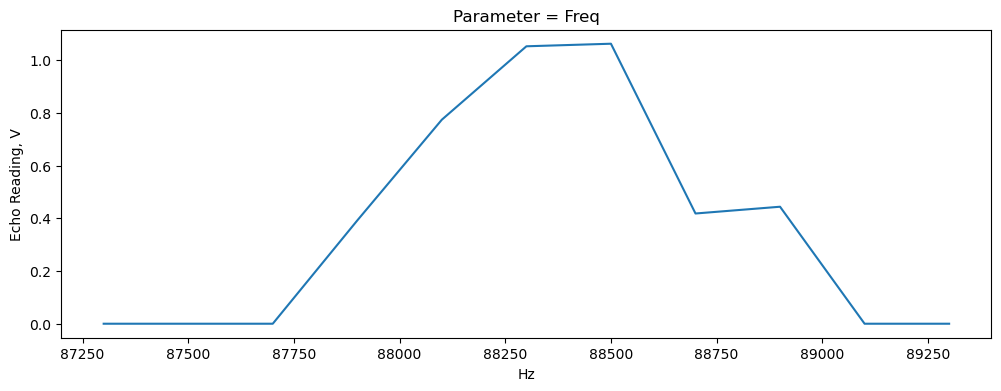

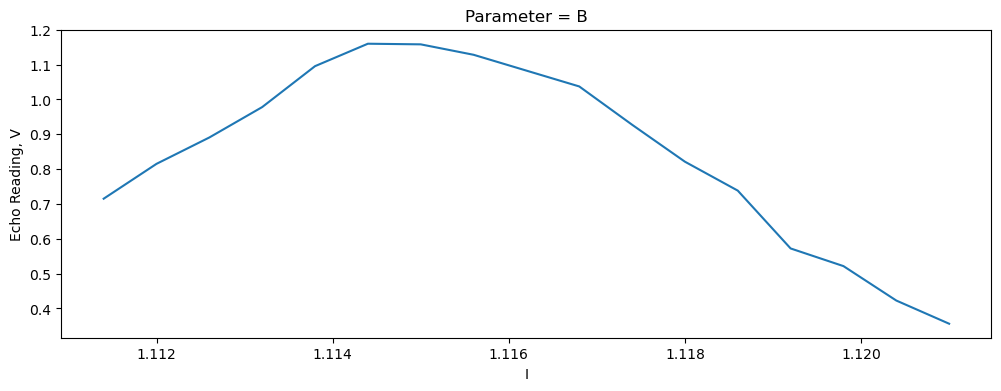

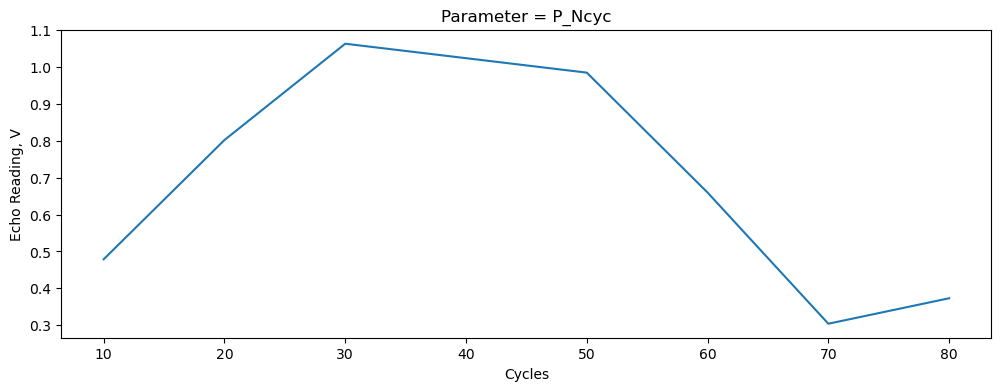

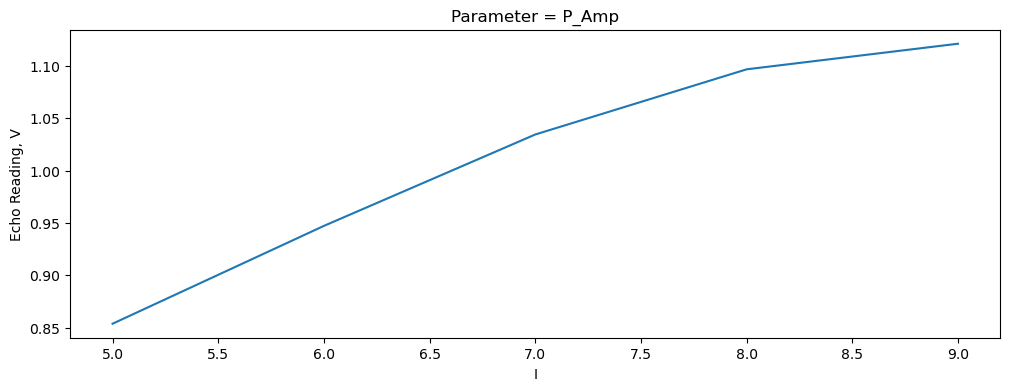

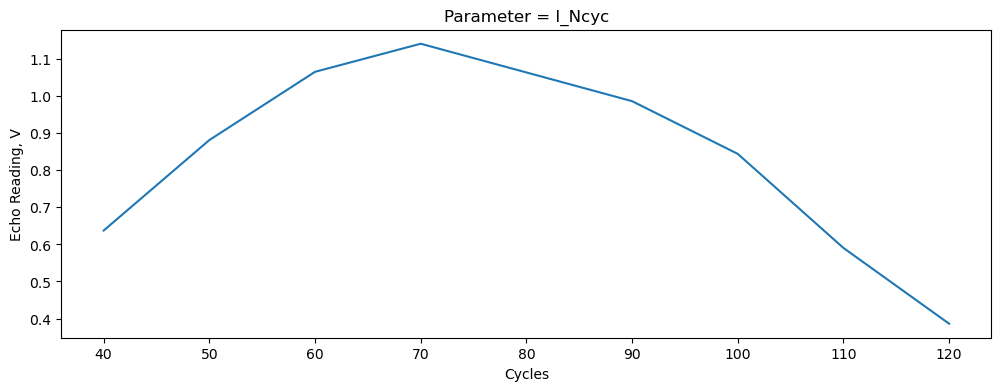

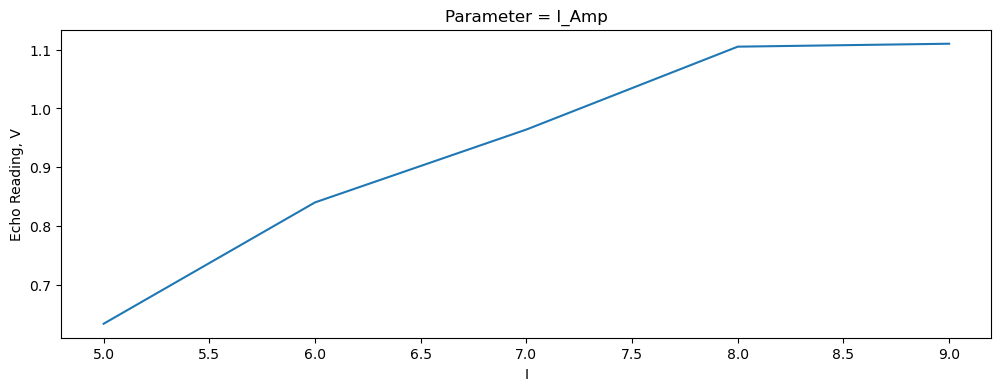

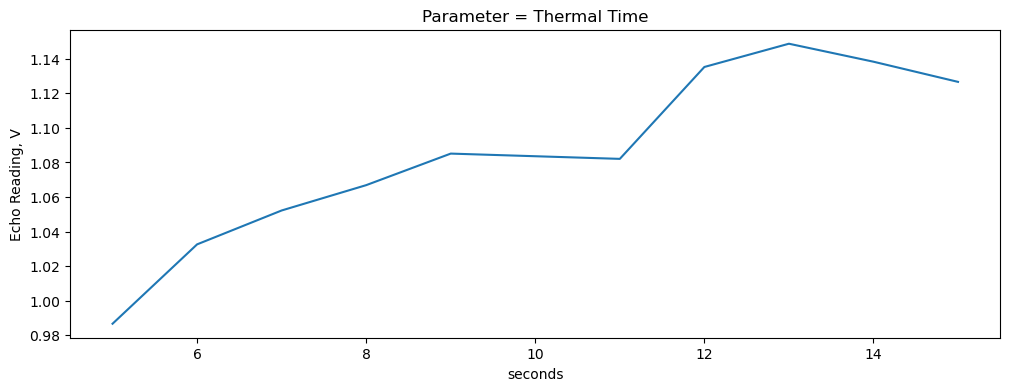

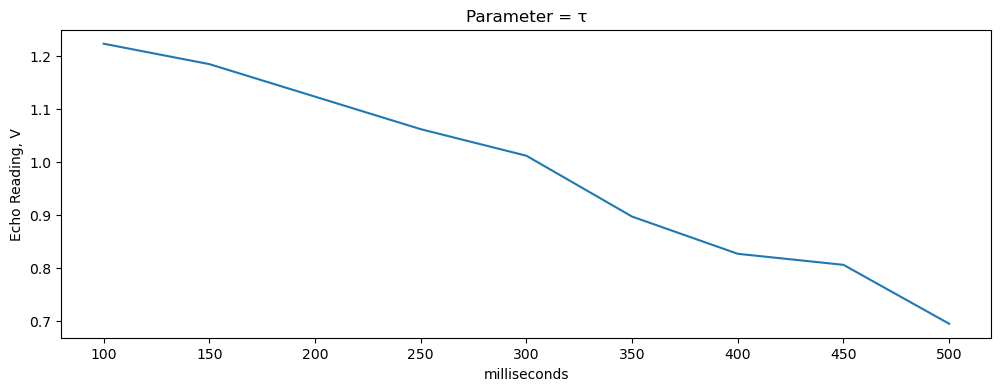

In [8]:
# Individual trial dataframes
param_dfs = [df_A,df_B,df_C,df_D,df_E,df_F,df_G,df_H]
# Parameters changed (mapped to the param_dfs above)
df_names=['Freq','B','P_Ncyc','P_Amp','I_Ncyc','I_Amp','Thermal Time','τ']
# Parameter units (could turn these all into a library in the future)
units=['Hz','I', 'Cycles','I','Cycles','I','seconds','milliseconds']

# Quick plots for each parameter
for _,df in enumerate(param_dfs):
    plt.figure(figsize=(12,4))
    plt.title(f'Parameter = {df_names[_]}')
    plt.ylabel('Echo Reading, V')
    plt.xlabel(units[_])
    plt.plot(df[df_names[_]],df.Max_V)
    plt.show()
    print()

#### Quick look - using all data, can a relationship between relative I_Pulse and P_Pulse intensity and spin echo response?

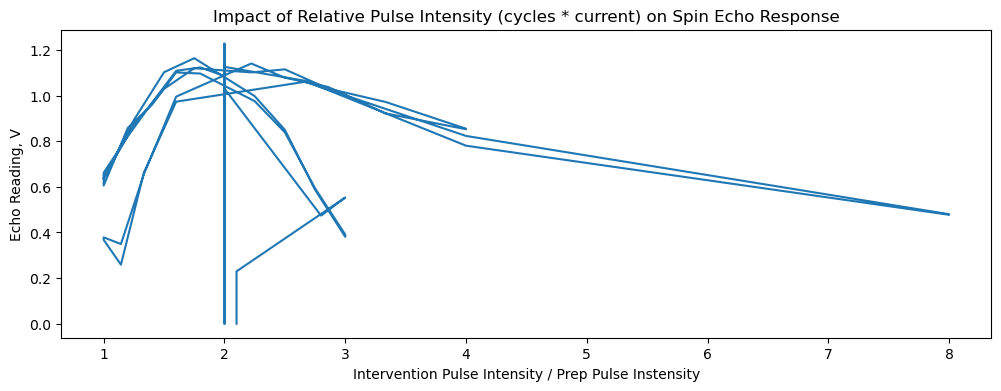

In [11]:
plt.figure(figsize=(12,4))
plt.plot(qc_data['I_Pulse / P_Pulse'],qc_data['Max_V'])
plt.title('Impact of Relative Pulse Intensity (cycles * current) on Spin Echo Response')
plt.ylabel('Echo Reading, V')
plt.xlabel('Intervention Pulse Intensity / Prep Pulse Instensity')
plt.show()

Interesting - regardless of other parameters, the response seems to peak when I/P is a little higher than 2.

#### 2.3. Make predictions and Test

Using Machine learning, see what should be the maximum for the echo.  Set it at that and see what happens.  See how well it predicts the outcome.

In [12]:
X = qc_data[['Freq', 'B', 'P_Ncyc', 'P_Amp', 'P_Pulse', 'I_Ncyc', 'I_Amp', 'I_Pulse',
       'I_Pulse / P_Pulse', 'τ', 'Thermal Time']]
Y1 = qc_data[['Max_V']]
Y2 = qc_data[['t_FWHM']]

In [13]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, Y1)

Go ahead and explore sklearn!